## Advantage actor-critic in AgentNet (5 pts)

Once we're done with REINFORCE, it's time to proceed with something more sophisticated.
The next one in line is advantage actor-critic, in which agent learns both policy and value function, using the latter to speed up learning.

Your main objective for this session is to... beat MountainCar-v0... with actor-critic.

Beating means making submission to [gym leaderboard](https://gym.openai.com/envs/MountainCar-v0).

``` MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials. ```


In [1]:
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [2]:
%env THEANO_FLAGS='floatX=float32'
# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
#     !bash ../xvfb start
#     %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


env: THEANO_FLAGS='floatX=float32'


In [3]:
import gym

env = gym.make("MountainCar-v0")
obs = env.reset()
observation_shape = env.observation_space.shape
state_size = len(obs)
n_actions = env.action_space.n
print(obs)

[2017-04-02 20:54:20,542] Making new env: MountainCar-v0


[-0.49394881  0.        ]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [4]:
from lasagne.layers import dnn 

In [5]:
from lasagne.layers import (InputLayer, ConcatLayer, Pool2DLayer, ReshapeLayer, DimshuffleLayer, NonlinearityLayer,
                            DropoutLayer, Deconv2DLayer, batch_norm)
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
except ImportError:
    from lasagne.layers import Conv2DLayer as ConvLayer
import lasagne

In [32]:

# from agentnet.memory import WindowAugmentation, LSTMCell

# prev_wnd = InputLayer((None,4)+observation_shape)
# new_wnd = WindowAugmentation(observation_layer,prev_wnd)
        
# #reshape to (frame, h,w). If you don't use grayscale, 4 should become 12.
# wnd_reshape = lasagne.layers.reshape(new_wnd, (-1,4*observation_shape[0])+observation_shape[1:])

In [96]:
observation_layer = InputLayer((None,state_size))

nn = lasagne.layers.DenseLayer(observation_layer, 16, nonlinearity=lasagne.nonlinearities.elu)
nn = lasagne.layers.DenseLayer(nn, 32,  nonlinearity=lasagne.nonlinearities.elu)
# nn = lasagne.layers.DenseLayer(nn, 128,  nonlinearity=lasagne.nonlinearities.elu)

In [34]:
# from agentnet.memory import LSTMCell

# prev_cell = InputLayer((None,256))
# prev_out = InputLayer((None,256))

# new_cell,new_out = LSTMCell(prev_cell,prev_out,nn,name='lstm')

#actor head
# logits_layer = lasagne.layers.DenseLayer(concat([nn,new_out]),n_actions,nonlinearity=None) 

# policy_layer = NonlinearityLayer(logits_layer,lasagne.nonlinearities.softmax)

#critic head
# V_layer = lasagne.layers.DenseLayer(concat([nn,new_out]),1,nonlinearity=None)



In [97]:
from lasagne.layers import concat
#a layer that predicts Qvalues

# policy_layer = <estimate probabilities of actions given prev layer. Mind the nonlinearity!>
logits_layer = lasagne.layers.DenseLayer(nn,n_actions,nonlinearity=None)
policy_layer = NonlinearityLayer(logits_layer,lasagne.nonlinearities.softmax)

# V_layer = <estimate state values (1 unit layer). Mind nonlinearity too.>
V_layer = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.softmax)

In [98]:
#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [99]:
from agentnet.agent import Agent
#all together

agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
#               agent_states={new_wnd:prev_wnd,new_cell:prev_cell,new_out:prev_out},
              action_layers=action_layer)

In [100]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[W, b, W, b, W, b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [101]:
from gym.wrappers import TimeLimit
class EnvMaker:
    def __init__(self, name, t_max):
        self.name = name
        self.t_max = t_max
        
    def __call__(self):
        env = gym.make(self.name).env
        env = TimeLimit(env, max_episode_steps=self.t_max)
        return env

In [102]:
from agentnet.experiments.openai_gym.pool import EnvPool

#create a small pool with 10 parallel agents
pool = EnvPool(agent,EnvMaker("MountainCar-v0", 10000), n_games=10,max_size=1000) 
# pool = EnvPool(agent,"MountainCar-v0", n_games=10,max_size=1000) 

#we assume that pool size 1000 is small enough to learn "almost on policy" :)

[2017-04-02 21:50:08,840] Making new env: MountainCar-v0
[2017-04-02 21:50:08,844] Making new env: MountainCar-v0
[2017-04-02 21:50:08,846] Making new env: MountainCar-v0
[2017-04-02 21:50:08,848] Making new env: MountainCar-v0
[2017-04-02 21:50:08,851] Making new env: MountainCar-v0
[2017-04-02 21:50:08,853] Making new env: MountainCar-v0
[2017-04-02 21:50:08,855] Making new env: MountainCar-v0
[2017-04-02 21:50:08,857] Making new env: MountainCar-v0
[2017-04-02 21:50:08,860] Making new env: MountainCar-v0
[2017-04-02 21:50:08,862] Making new env: MountainCar-v0


In [103]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:3])
print(reward_log[:3])

[[2 0 1 2 1 0 0]
 [0 2 0 2 0 2 0]
 [0 1 2 1 0 1 1]]
[[-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 8.7 ms


In [104]:
SEQ_LENGTH = 10
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Actor-critic loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [105]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)



In [106]:
from agentnet.learning import a2c                                                   


elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,
                                                V_seq[:,:,0],
                                                replay.actions[0],
                                                replay.rewards,
                                                replay.is_alive,
                                                gamma_or_gammas=0.99,
                                                n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

loss += 0.01*(1./(policy_seq)).sum(-1).mean()

In [107]:
from theano import tensor as T
# loss += 0.001 * (policy_seq * T.log(policy_seq)).sum().mean()

In [108]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [109]:
import theano
train_step = theano.function([],loss,updates=updates)

Exception ignored in: <bound method Monitor.__del__ of <Monitor<TimeLimit<MountainCarEnv<MountainCar-v0>>>>>
Traceback (most recent call last):
  File "/home/ubuntu/gym/gym/wrappers/monitoring.py", line 239, in __del__
    self.close()
  File "/home/ubuntu/gym/gym/wrappers/monitoring.py", line 147, in close
    self._close_video_recorder()
  File "/home/ubuntu/gym/gym/wrappers/monitoring.py", line 222, in _close_video_recorder
    self.video_recorder.close()
  File "/home/ubuntu/gym/gym/monitoring/video_recorder.py", line 134, in close
    os.remove(self.path)
FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/records/openaigym.video.31.3612.video000000.mp4'


# Demo run

In [ ]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
# untrained_reward = pool.evaluate(save_path="./records",record_video=True)

#video is in the ./records folder

# Training loop


In [111]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}

In [117]:
from tqdm import tqdm
#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in range(20000):    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = loss*0.99 + train_step()*0.01
#     print(loss, train_step())
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        print("iter=%i\treward/step=%.5f\tloss ma=%.5f"%(epoch_counter,
                                                        pool_mean_reward,
                                                        loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=10100	reward/step=-0.99994	loss ma=-0.05290
iter=10200	reward/step=-1.00000	loss ma=0.04764
iter=10300	reward/step=-0.99978	loss ma=0.11194
iter=10400	reward/step=-0.99994	loss ma=0.06460


[2017-04-02 22:11:21,559] Making new env: MountainCar-v0
[2017-04-02 22:11:21,562] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10500	reward/step=-0.99994	loss ma=0.04621


[2017-04-02 22:12:15,554] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=10600	reward/step=-0.99994	loss ma=0.10614
iter=10700	reward/step=-1.00000	loss ma=0.05976
iter=10800	reward/step=-0.99994	loss ma=0.03368
iter=10900	reward/step=-0.99989	loss ma=0.14037


[2017-04-02 22:12:27,303] Making new env: MountainCar-v0
[2017-04-02 22:12:27,306] Clearing 2 monitor files from previous run (because force=True was provided)


iter=11000	reward/step=-1.00000	loss ma=0.07708


[2017-04-02 22:13:21,343] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=11100	reward/step=-0.99994	loss ma=-0.06858
iter=11200	reward/step=-0.99983	loss ma=-0.03470
iter=11300	reward/step=-1.00000	loss ma=-0.22002
iter=11400	reward/step=-0.99978	loss ma=-0.26632


[2017-04-02 22:13:33,224] Making new env: MountainCar-v0
[2017-04-02 22:13:33,227] Clearing 2 monitor files from previous run (because force=True was provided)


iter=11500	reward/step=-1.00000	loss ma=-0.16910


[2017-04-02 22:14:27,201] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=11600	reward/step=-0.99994	loss ma=-0.12732
iter=11700	reward/step=-0.99994	loss ma=-0.02350
iter=11800	reward/step=-1.00000	loss ma=0.02063
iter=11900	reward/step=-0.99994	loss ma=0.09324


[2017-04-02 22:14:38,974] Making new env: MountainCar-v0
[2017-04-02 22:14:38,977] Clearing 2 monitor files from previous run (because force=True was provided)


iter=12000	reward/step=-0.99983	loss ma=0.06887


[2017-04-02 22:14:57,461] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -3421.100
iter=12100	reward/step=-1.00000	loss ma=0.05965
iter=12200	reward/step=-1.00000	loss ma=0.15238
iter=12300	reward/step=-0.99989	loss ma=0.18164
iter=12400	reward/step=-1.00000	loss ma=0.09818


[2017-04-02 22:15:09,391] Making new env: MountainCar-v0
[2017-04-02 22:15:09,394] Clearing 2 monitor files from previous run (because force=True was provided)


iter=12500	reward/step=-0.99978	loss ma=0.07354


[2017-04-02 22:15:35,199] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -4804.200
iter=12600	reward/step=-1.00000	loss ma=0.07401
iter=12700	reward/step=-0.99994	loss ma=0.04702
iter=12800	reward/step=-0.99994	loss ma=0.03974
iter=12900	reward/step=-1.00000	loss ma=0.02908


[2017-04-02 22:15:47,100] Making new env: MountainCar-v0
[2017-04-02 22:15:47,102] Clearing 2 monitor files from previous run (because force=True was provided)


iter=13000	reward/step=-1.00000	loss ma=0.01966


[2017-04-02 22:16:33,431] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -8600.200
iter=13100	reward/step=-0.99989	loss ma=0.01359
iter=13200	reward/step=-0.99994	loss ma=0.01384
iter=13300	reward/step=-1.00000	loss ma=0.01291
iter=13400	reward/step=-0.99978	loss ma=0.01053


[2017-04-02 22:16:45,151] Making new env: MountainCar-v0
[2017-04-02 22:16:45,154] Clearing 2 monitor files from previous run (because force=True was provided)


iter=13500	reward/step=-0.99994	loss ma=0.01208


[2017-04-02 22:17:15,487] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -5625.900
iter=13600	reward/step=-0.99989	loss ma=0.01847
iter=13700	reward/step=-1.00000	loss ma=0.01542
iter=13800	reward/step=-0.99994	loss ma=0.01732
iter=13900	reward/step=-1.00000	loss ma=0.02106


[2017-04-02 22:17:27,213] Making new env: MountainCar-v0
[2017-04-02 22:17:27,216] Clearing 2 monitor files from previous run (because force=True was provided)


iter=14000	reward/step=-1.00000	loss ma=0.01269


[2017-04-02 22:18:09,468] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7858.400
iter=14100	reward/step=-0.99983	loss ma=0.01009
iter=14200	reward/step=-0.99989	loss ma=0.11477
iter=14300	reward/step=-0.99994	loss ma=0.03634
iter=14400	reward/step=-1.00000	loss ma=0.15368


[2017-04-02 22:18:21,324] Making new env: MountainCar-v0
[2017-04-02 22:18:21,327] Clearing 2 monitor files from previous run (because force=True was provided)


iter=14500	reward/step=-0.99983	loss ma=-0.00254


[2017-04-02 22:19:03,230] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7795.200
iter=14600	reward/step=-1.00000	loss ma=0.07679
iter=14700	reward/step=-0.99983	loss ma=-0.19135
iter=14800	reward/step=-1.00000	loss ma=-0.23701
iter=14900	reward/step=-1.00000	loss ma=-0.25868


[2017-04-02 22:19:15,107] Making new env: MountainCar-v0
[2017-04-02 22:19:15,110] Clearing 2 monitor files from previous run (because force=True was provided)


iter=15000	reward/step=-0.99989	loss ma=-0.27362


[2017-04-02 22:20:09,204] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=15100	reward/step=-1.00000	loss ma=-0.18967
iter=15200	reward/step=-0.99983	loss ma=-0.08709
iter=15300	reward/step=-0.99994	loss ma=-0.03497
iter=15400	reward/step=-1.00000	loss ma=0.11577


[2017-04-02 22:20:20,917] Making new env: MountainCar-v0
[2017-04-02 22:20:20,920] Clearing 2 monitor files from previous run (because force=True was provided)


iter=15500	reward/step=-1.00000	loss ma=0.14383


[2017-04-02 22:21:14,924] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=15600	reward/step=-0.99989	loss ma=0.02922
iter=15700	reward/step=-0.99994	loss ma=0.06939
iter=15800	reward/step=-0.99989	loss ma=0.11854
iter=15900	reward/step=-0.99994	loss ma=0.11431


[2017-04-02 22:21:26,798] Making new env: MountainCar-v0
[2017-04-02 22:21:26,801] Clearing 2 monitor files from previous run (because force=True was provided)


iter=16000	reward/step=-1.00000	loss ma=0.09294


[2017-04-02 22:22:21,984] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=16100	reward/step=-0.99994	loss ma=0.09688
iter=16200	reward/step=-1.00000	loss ma=0.03726
iter=16300	reward/step=-0.99989	loss ma=0.04190
iter=16400	reward/step=-0.99994	loss ma=0.04220


[2017-04-02 22:22:33,745] Making new env: MountainCar-v0
[2017-04-02 22:22:33,748] Clearing 2 monitor files from previous run (because force=True was provided)


iter=16500	reward/step=-0.99994	loss ma=0.02442


[2017-04-02 22:23:13,622] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7371.300
iter=16600	reward/step=-1.00000	loss ma=0.02495
iter=16700	reward/step=-0.99972	loss ma=0.04589
iter=16800	reward/step=-0.99994	loss ma=0.01762
iter=16900	reward/step=-0.99994	loss ma=0.03638


[2017-04-02 22:23:25,492] Making new env: MountainCar-v0
[2017-04-02 22:23:25,495] Clearing 2 monitor files from previous run (because force=True was provided)


iter=17000	reward/step=-0.99994	loss ma=0.05260


[2017-04-02 22:24:19,698] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=17100	reward/step=-1.00000	loss ma=0.03169
iter=17200	reward/step=-0.99994	loss ma=0.02091
iter=17300	reward/step=-0.99967	loss ma=0.12842
iter=17400	reward/step=-1.00000	loss ma=0.03560


[2017-04-02 22:24:31,523] Making new env: MountainCar-v0
[2017-04-02 22:24:31,526] Clearing 2 monitor files from previous run (because force=True was provided)


iter=17500	reward/step=-0.99994	loss ma=-0.00666


[2017-04-02 22:25:25,726] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=17600	reward/step=-0.99994	loss ma=-0.03347
iter=17700	reward/step=-0.99994	loss ma=-0.04880
iter=17800	reward/step=-1.00000	loss ma=-0.15609
iter=17900	reward/step=-0.99989	loss ma=-0.31986


[2017-04-02 22:25:37,611] Making new env: MountainCar-v0
[2017-04-02 22:25:37,615] Clearing 2 monitor files from previous run (because force=True was provided)


iter=18000	reward/step=-1.00000	loss ma=-0.24451


[2017-04-02 22:26:32,852] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=18100	reward/step=-0.99989	loss ma=-0.12623
iter=18200	reward/step=-1.00000	loss ma=-0.06798
iter=18300	reward/step=-1.00000	loss ma=-0.04033
iter=18400	reward/step=-0.99967	loss ma=-0.06759


[2017-04-02 22:26:44,561] Making new env: MountainCar-v0
[2017-04-02 22:26:44,565] Clearing 2 monitor files from previous run (because force=True was provided)


iter=18500	reward/step=-0.99994	loss ma=0.07354


[2017-04-02 22:27:38,910] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=18600	reward/step=-0.99994	loss ma=0.15550
iter=18700	reward/step=-1.00000	loss ma=0.11241
iter=18800	reward/step=-0.99989	loss ma=0.00970
iter=18900	reward/step=-0.99994	loss ma=0.15967


[2017-04-02 22:27:50,794] Making new env: MountainCar-v0
[2017-04-02 22:27:50,797] Clearing 2 monitor files from previous run (because force=True was provided)


iter=19000	reward/step=-0.99989	loss ma=0.11871


[2017-04-02 22:28:45,160] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=19100	reward/step=-1.00000	loss ma=0.11821
iter=19200	reward/step=-1.00000	loss ma=0.07767
iter=19300	reward/step=-1.00000	loss ma=0.11170
iter=19400	reward/step=-0.99983	loss ma=0.05486


[2017-04-02 22:28:56,872] Making new env: MountainCar-v0
[2017-04-02 22:28:56,875] Clearing 2 monitor files from previous run (because force=True was provided)


iter=19500	reward/step=-1.00000	loss ma=0.10510


[2017-04-02 22:29:38,936] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7741.300
iter=19600	reward/step=-0.99994	loss ma=0.06417
iter=19700	reward/step=-0.99994	loss ma=0.03166
iter=19800	reward/step=-1.00000	loss ma=0.01887
iter=19900	reward/step=-0.99989	loss ma=0.01493


[2017-04-02 22:29:50,817] Making new env: MountainCar-v0
[2017-04-02 22:29:50,820] Clearing 2 monitor files from previous run (because force=True was provided)


iter=20000	reward/step=-0.99994	loss ma=0.01239


[2017-04-02 22:30:44,737] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -9957.800
iter=20100	reward/step=-0.99989	loss ma=0.01113
iter=20200	reward/step=-1.00000	loss ma=0.01093
iter=20300	reward/step=-1.00000	loss ma=0.01016
iter=20400	reward/step=-1.00000	loss ma=0.00998


[2017-04-02 22:30:56,567] Making new env: MountainCar-v0
[2017-04-02 22:30:56,570] Clearing 2 monitor files from previous run (because force=True was provided)


iter=20500	reward/step=-0.99983	loss ma=0.01034


[2017-04-02 22:31:51,045] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=20600	reward/step=-0.99994	loss ma=0.01128
iter=20700	reward/step=-1.00000	loss ma=0.01105
iter=20800	reward/step=-0.99989	loss ma=0.01149
iter=20900	reward/step=-1.00000	loss ma=0.01103


[2017-04-02 22:32:02,949] Making new env: MountainCar-v0
[2017-04-02 22:32:02,951] Clearing 2 monitor files from previous run (because force=True was provided)


iter=21000	reward/step=-0.99989	loss ma=0.01021


[2017-04-02 22:32:50,292] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -8720.300
iter=21100	reward/step=-0.99989	loss ma=0.01400
iter=21200	reward/step=-0.99994	loss ma=0.01269
iter=21300	reward/step=-1.00000	loss ma=0.01124
iter=21400	reward/step=-1.00000	loss ma=0.01786


[2017-04-02 22:33:02,178] Making new env: MountainCar-v0
[2017-04-02 22:33:02,181] Clearing 2 monitor files from previous run (because force=True was provided)


iter=21500	reward/step=-1.00000	loss ma=0.03477


[2017-04-02 22:33:56,296] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=21600	reward/step=-0.99983	loss ma=0.02553
iter=21700	reward/step=-0.99989	loss ma=0.03343
iter=21800	reward/step=-1.00000	loss ma=-0.01466
iter=21900	reward/step=-0.99978	loss ma=-0.22137


[2017-04-02 22:34:08,169] Making new env: MountainCar-v0
[2017-04-02 22:34:08,172] Clearing 2 monitor files from previous run (because force=True was provided)


iter=22000	reward/step=-1.00000	loss ma=-0.36045


[2017-04-02 22:35:02,395] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=22100	reward/step=-0.99994	loss ma=-0.35452
iter=22200	reward/step=-0.99994	loss ma=-0.30656
iter=22300	reward/step=-0.99983	loss ma=-0.28801
iter=22400	reward/step=-1.00000	loss ma=-0.18346


[2017-04-02 22:35:14,246] Making new env: MountainCar-v0
[2017-04-02 22:35:14,249] Clearing 2 monitor files from previous run (because force=True was provided)


iter=22500	reward/step=-1.00000	loss ma=-0.07207


[2017-04-02 22:36:08,767] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=22600	reward/step=-0.99989	loss ma=-0.06905
iter=22700	reward/step=-0.99983	loss ma=0.01471
iter=22800	reward/step=-0.99994	loss ma=0.08529
iter=22900	reward/step=-1.00000	loss ma=0.14765


[2017-04-02 22:36:20,630] Making new env: MountainCar-v0
[2017-04-02 22:36:20,633] Clearing 2 monitor files from previous run (because force=True was provided)


iter=23000	reward/step=-0.99972	loss ma=0.04295


[2017-04-02 22:36:53,153] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -6008.900
iter=23100	reward/step=-0.99994	loss ma=0.14040
iter=23200	reward/step=-0.99994	loss ma=0.13014
iter=23300	reward/step=-1.00000	loss ma=0.11958
iter=23400	reward/step=-0.99994	loss ma=0.06698


[2017-04-02 22:37:05,030] Making new env: MountainCar-v0
[2017-04-02 22:37:05,034] Clearing 2 monitor files from previous run (because force=True was provided)


iter=23500	reward/step=-1.00000	loss ma=0.07221


[2017-04-02 22:37:42,099] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -6832.900
iter=23600	reward/step=-0.99994	loss ma=0.04573
iter=23700	reward/step=-0.99994	loss ma=0.03069
iter=23800	reward/step=-0.99994	loss ma=0.02460
iter=23900	reward/step=-1.00000	loss ma=0.01793


[2017-04-02 22:37:54,006] Making new env: MountainCar-v0
[2017-04-02 22:37:54,009] Clearing 2 monitor files from previous run (because force=True was provided)


iter=24000	reward/step=-0.99994	loss ma=0.01387


[2017-04-02 22:38:48,563] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=24100	reward/step=-0.99972	loss ma=0.01197
iter=24200	reward/step=-1.00000	loss ma=0.01077
iter=24300	reward/step=-1.00000	loss ma=0.01062
iter=24400	reward/step=-1.00000	loss ma=0.01200


[2017-04-02 22:39:00,352] Making new env: MountainCar-v0
[2017-04-02 22:39:00,355] Clearing 2 monitor files from previous run (because force=True was provided)


iter=24500	reward/step=-0.99994	loss ma=0.01129


[2017-04-02 22:39:49,185] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -9047.300
iter=24600	reward/step=-1.00000	loss ma=0.01157
iter=24700	reward/step=-0.99994	loss ma=0.01145
iter=24800	reward/step=-0.99983	loss ma=0.01146
iter=24900	reward/step=-1.00000	loss ma=0.01141


[2017-04-02 22:40:01,061] Making new env: MountainCar-v0
[2017-04-02 22:40:01,064] Clearing 2 monitor files from previous run (because force=True was provided)


iter=25000	reward/step=-1.00000	loss ma=0.01120


[2017-04-02 22:40:53,433] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -9618.000
iter=25100	reward/step=-0.99994	loss ma=0.03752
iter=25200	reward/step=-0.99983	loss ma=0.14449
iter=25300	reward/step=-0.99989	loss ma=0.02251
iter=25400	reward/step=-0.99989	loss ma=0.15658


[2017-04-02 22:41:05,124] Making new env: MountainCar-v0
[2017-04-02 22:41:05,127] Clearing 2 monitor files from previous run (because force=True was provided)


iter=25500	reward/step=-1.00000	loss ma=0.00768


[2017-04-02 22:42:00,174] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=25600	reward/step=-0.99983	loss ma=-0.13996
iter=25700	reward/step=-0.99989	loss ma=-0.22062
iter=25800	reward/step=-1.00000	loss ma=-0.37127
iter=25900	reward/step=-0.99994	loss ma=-0.24304


[2017-04-02 22:42:12,054] Making new env: MountainCar-v0
[2017-04-02 22:42:12,057] Clearing 2 monitor files from previous run (because force=True was provided)


iter=26000	reward/step=-0.99994	loss ma=-0.10709


[2017-04-02 22:42:32,891] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -3847.000
iter=26100	reward/step=-1.00000	loss ma=-0.11054
iter=26200	reward/step=-1.00000	loss ma=-0.04427
iter=26300	reward/step=-0.99983	loss ma=0.01429
iter=26400	reward/step=-0.99978	loss ma=0.00709


[2017-04-02 22:42:44,768] Making new env: MountainCar-v0
[2017-04-02 22:42:44,772] Clearing 2 monitor files from previous run (because force=True was provided)


iter=26500	reward/step=-1.00000	loss ma=0.06203


[2017-04-02 22:43:39,251] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=26600	reward/step=-1.00000	loss ma=0.07365
iter=26700	reward/step=-0.99978	loss ma=0.02034
iter=26800	reward/step=-0.99994	loss ma=0.04937
iter=26900	reward/step=-1.00000	loss ma=0.14005


[2017-04-02 22:43:51,078] Making new env: MountainCar-v0
[2017-04-02 22:43:51,080] Clearing 2 monitor files from previous run (because force=True was provided)


iter=27000	reward/step=-1.00000	loss ma=0.17050


[2017-04-02 22:44:45,267] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=27100	reward/step=-0.99994	loss ma=0.10586
iter=27200	reward/step=-0.99994	loss ma=0.08866
iter=27300	reward/step=-1.00000	loss ma=0.17002
iter=27400	reward/step=-0.99994	loss ma=0.08083


[2017-04-02 22:44:57,139] Making new env: MountainCar-v0
[2017-04-02 22:44:57,142] Clearing 2 monitor files from previous run (because force=True was provided)


iter=27500	reward/step=-0.99983	loss ma=0.06146


[2017-04-02 22:45:51,615] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=27600	reward/step=-1.00000	loss ma=0.05945
iter=27700	reward/step=-0.99994	loss ma=0.03816
iter=27800	reward/step=-0.99983	loss ma=0.02606
iter=27900	reward/step=-1.00000	loss ma=0.01721


[2017-04-02 22:46:03,361] Making new env: MountainCar-v0
[2017-04-02 22:46:03,364] Clearing 2 monitor files from previous run (because force=True was provided)


iter=28000	reward/step=-1.00000	loss ma=0.01272


[2017-04-02 22:46:52,754] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -9081.900
iter=28100	reward/step=-1.00000	loss ma=0.01125
iter=28200	reward/step=-0.99994	loss ma=0.01053
iter=28300	reward/step=-0.99994	loss ma=0.01173
iter=28400	reward/step=-1.00000	loss ma=0.01342


[2017-04-02 22:47:04,639] Making new env: MountainCar-v0
[2017-04-02 22:47:04,642] Clearing 2 monitor files from previous run (because force=True was provided)


iter=28500	reward/step=-1.00000	loss ma=0.01103


[2017-04-02 22:47:45,880] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7518.600
iter=28600	reward/step=-0.99972	loss ma=0.01227
iter=28700	reward/step=-1.00000	loss ma=0.01604
iter=28800	reward/step=-0.99994	loss ma=0.00957
iter=28900	reward/step=-0.99989	loss ma=0.02994


[2017-04-02 22:47:57,759] Making new env: MountainCar-v0
[2017-04-02 22:47:57,762] Clearing 2 monitor files from previous run (because force=True was provided)


iter=29000	reward/step=-1.00000	loss ma=0.14850


[2017-04-02 22:48:52,068] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -10000.000
iter=29100	reward/step=-1.00000	loss ma=0.07160
iter=29200	reward/step=-0.99983	loss ma=-0.01674
iter=29300	reward/step=-0.99994	loss ma=0.12341
iter=29400	reward/step=-1.00000	loss ma=0.04569


[2017-04-02 22:49:03,880] Making new env: MountainCar-v0
[2017-04-02 22:49:03,883] Clearing 2 monitor files from previous run (because force=True was provided)


iter=29500	reward/step=-1.00000	loss ma=0.09085


[2017-04-02 22:49:47,272] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -7945.300
iter=29600	reward/step=-0.99983	loss ma=0.03428
iter=29700	reward/step=-0.99978	loss ma=0.12713
iter=29800	reward/step=-1.00000	loss ma=0.09169
iter=29900	reward/step=-1.00000	loss ma=-0.00983


[2017-04-02 22:49:59,169] Making new env: MountainCar-v0
[2017-04-02 22:49:59,172] Clearing 2 monitor files from previous run (because force=True was provided)


iter=30000	reward/step=-1.00000	loss ma=0.08478


[2017-04-02 22:50:44,830] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/ubuntu/records')


Current score(mean over 10) = -8413.700


In [118]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda kv:kv[0]))

In [119]:
sr = [np.mean(s) for s in session_rewards]

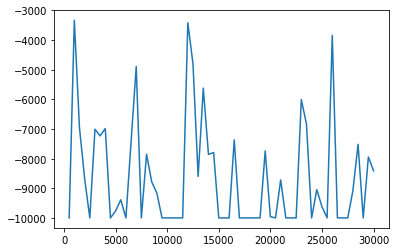

In [120]:
plt.plot(iters,sr)

### Visualizing the $V(s)$ and  $\pi(a|s)$

Since the observation space is just 2-dimensional, we can plot it on a 2d scatter-plot to gain insight of what agent learned.

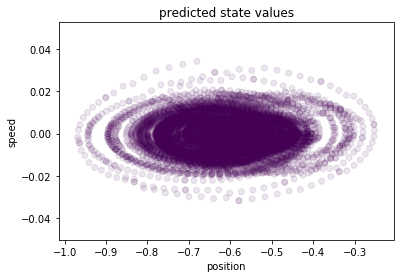

In [39]:
_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

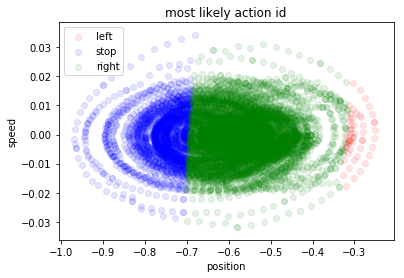

In [40]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()
action_names=["left","stop","right"]
for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')

### Variations in the algorithm (2 pts)

Try different `n_steps` param to see if it improves learning performance.

Your objective is to compare learning curves for 1, 3, 10 and 25-step updates (or any grid you think is appropriate).

For 25-step updates, please also increase SEQ_LENGTH to 25.

Also evaluate how performance changes with different entropy regularizer coefficient.

_bonus_ See if you can learn effectively without experience replay (may need a lot of parallel agents)

In [ ]:
#<a lot of your code here>

### Bonus section (5+ pts)

Beat the [`LunarLanderContinuous-v2`](https://gym.openai.com/envs/LunarLanderContinuous-v2) with continuous version of advantage actor-critic.

You will require a multidimensional gaussian (or similar) policy from your agent.

You can implement that by feeding a2c.get_elementwise_objective probabilities of agent's chosen actions (it will be 2-dimensional) instead of all actions.

Contact us if you have any questions.